In the case when the ground state is a common state of both spin species, we resort to a spin-1 formulation, the following code implements the mean field of this description 

In [1]:
using DifferentialEquations, PyPlot, Statistics, LaTeXStrings, PyCall, LinearAlgebra, FFTW

In [118]:
ENV["PYTHON"] = "C:\\Users\\admin\\Anaconda3\\envs\\data_vis\\python.exe"

LogNorm = pyimport("matplotlib.colors").LogNorm
cmap = pyimport("cmap")

lajolla = cmap.Colormap("crameri:lajolla").to_mpl();
balance = cmap.Colormap("cmocean:balance").to_mpl();
oslo = cmap.Colormap("crameri:oslo").to_mpl();
lipari = cmap.Colormap("crameri:lipari").to_mpl();
eclipse = cmap.Colormap("cmasher:eclipse").to_mpl();
bilbao = cmap.Colormap("crameri:bilbao").to_mpl();


# Configure LaTeX rendering and fonts
PyPlot.matplotlib[:rc]("text", usetex=true)
PyPlot.matplotlib[:rc]("font", family="serif", serif=["mathpazo"], size=18)  # Base font size
PyPlot.matplotlib[:rc]("axes", titlesize=22)             # Axis title
PyPlot.matplotlib[:rc]("axes", labelsize=20)             # Axis labels
PyPlot.matplotlib[:rc]("xtick", labelsize=18)            # X-ticks
PyPlot.matplotlib[:rc]("ytick", labelsize=18)            # Y-ticks
PyPlot.matplotlib[:rc]("legend", fontsize=18)            # Legend
PyPlot.matplotlib[:rc]("figure", titlesize=24)           # Figure title
PyPlot.svg(true)
# LaTeX preamble packages
PyPlot.matplotlib[:rc]("text.latex", preamble="\\usepackage{amsmath}\\usepackage{amsfonts}\\usepackage{amssymb}\\usepackage{lmodern}")

In [3]:
""" 

######
        build Gell-Mann λ-matrices for the su(3) algebra (NOTE 1/2 factor)
#######

"""

λ1 = 1/2 * [0 1 0;
        1 0 0;
        0 0 0]

λ2 = 1/2*[0 -im  0;
        im  0  0;
        0   0  0]

λ3 = 1/2*[1  0 0;
        0 -1 0;
        0  0 0]

λ4 = 1/2*[0 0 1;
        0 0 0;
        1 0 0]

λ5 = 1/2*[0  0 -im;
        0  0   0;
        im 0   0]

λ6 = 1/2*[0 0 0;
        0 0 1;
        0 1 0]

λ7 = 1/2*[0  0   0;
        0  0  -im;
        0  im  0]
        
λ8 = (1/(2*sqrt(3)))*[1   0   0;
                0   1   0;
                0   0  -2]

                

λ_matrices = [λ1, λ2, λ3, λ4, λ5, λ6, λ7, λ8]

sum(λ_matrices[i]^2 for i in 1:8)


"""
    su3_d_tensor(lambdas::Vector{<:AbstractMatrix})

Compute the fully symmetric d_{i,j,k} tensor for SU(3) by
d[i,j,k] = 1/4 * tr( (lambdas[i]*lambdas[j] + lambdas[j]*lambdas[i]) * lambdas[k] ).
Returns an Array{Float64,3} of size (8,8,8).
"""
function su3_d_tensor(lambdas::Vector{Matrix{ComplexF64}})
    d = zeros(Float64, 8, 8, 8)
    for i in 1:8, j in 1:8, k in 1:8
        # compute the anticommutator {λ_i, λ_j}
        A = lambdas[i]*lambdas[j] + lambdas[j]*lambdas[i]

        d[i, j, k] = real(tr(A * lambdas[k]) / 4)
    end
    return d
end

#Sum with cubic casimir of lambda matrices
dsu3 = su3_d_tensor(λ_matrices);

C3m = zeros(ComplexF64, 3, 3)

# sum over i,j,k
for i in 1:8, j in 1:8, k in 1:8
    C3m .+= dsu3[i, j, k] * (λ_matrices[i] * λ_matrices[j] * λ_matrices[k])
end

In [4]:
N1m = I(3)/3 + λ3 + 1/sqrt(3)*λ8
N0m = I(3)/3 - λ3 + 1/sqrt(3)*λ8
N2m = I(3)/3 - 2/sqrt(3)*λ8;

In [5]:
sum(λ_matrices[i]^2 for i in 1:8)

C3m

3×3 Matrix{ComplexF64}:
 0.138889+0.0im       0.0+0.0im       0.0+0.0im
      0.0+0.0im  0.138889+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im  0.138889+0.0im

In [302]:
A = 0
γ = 0
β = 0
B = 0
C = sqrt(1-A^2-B^2)

a1 = A*B*cos(β)
a2 = A*B*sin(β)
a3 = 1/2*(A^2-B^2)
a4 = A*C*cos(γ)
a5 = A*C*sin(γ)
a6 = B*C*cos(γ-β)
a7 = B*C*sin(γ-β)
a8 = (-2+3*A^2+3B^2)/(2*sqrt(3))

# a1 = 0
# a2 = 0
# a3 = 0
# a4 = 0
# a5 = 0
# a6 = 0
# a7 = 0
# a8 = 0

# Definition of density matrix
rho0 = [1/3+a3+a8/sqrt(3) a1-im*a2 a4-im*a5;
a1+im*a2 1/3-a3+a8/sqrt(3) a6-im*a7;
a4+im*a5 a6+im*a7 1/3-2/sqrt(3)*a8]

# Physicality checks on rho & entries
det(rho0)
avec = [a1,a2,a3,a4,a5,a6,a7,a8]
sum(avec.^2)

0.3333333333333334

In [303]:
rho0

3×3 Matrix{ComplexF64}:
 -5.55112e-17+0.0im           0.0-0.0im  0.0-0.0im
          0.0+0.0im  -5.55112e-17+0.0im  0.0-0.0im
          0.0+0.0im           0.0+0.0im  1.0+0.0im

In [304]:
C3m = zeros(ComplexF64, 3, 3)
for i in 1:8, j in 1:8, k in 1:8
    C3m .+= (rho0 * dsu3[i, j, k] * (λ_matrices[i] * λ_matrices[j] * λ_matrices[k]))
end
tr(C3m)


# tr(rho0*λ8)

0.1388888888888889 + 0.0im

In [305]:
sum(λ_matrices[i]^2 for i in 1:8)

# C3m

3×3 Matrix{ComplexF64}:
 1.33333+0.0im      0.0+0.0im      0.0+0.0im
     0.0+0.0im  1.33333+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im  1.33333+0.0im

In [306]:
# Define the system of ODEs
function coupled_eqs!(du, u, p, t)
    Δ1, Δ2, g, φ, Δ, κ, η = p
    λ1, λ2, λ3, λ4, λ5, λ6, λ7, λ8, α_re, α_im = u

    # reconstruct complex field
    α    = α_re + im*α_im
    αc   = conj(α)
    expp = cis(φ)               # e^{iφ}
    expm = conj(expp)           # e^{-iφ}

    # λ-derivatives 
    dλ1 = -Δ1*λ2 + im*g*(λ3*(α-αc) + expm*αc/2*(-im*λ5+λ4) + expp*α/2*(-im*λ5-λ4))
    dλ2 =  Δ1*λ1 + im*g*(im*λ3*(α+αc) + expm*αc/2*(im*λ4+λ5) + expp*α/2*(im*λ4-λ5))
    dλ3 =  im*g*(-im*λ2*(α+αc) + λ1*(αc-α) + expm*αc/2*(im*λ7-λ6) + expp*α/2*(im*λ7+λ6))
    dλ4 = (Δ1-Δ2)*λ5 + im*g*(αc/2*(im*λ7+λ6) + α/2*(im*λ7-λ6) + expm*αc/2*(-im*λ2-λ1) + expp*α/2*(-im*λ2+λ1))
    dλ5 = -(Δ1-Δ2)*λ4 + im*g*(αc/2*(-im*λ6+λ7) + α/2*(-im*λ6-λ7) + expm*αc/2*(im*λ1-λ2) + expp*α/2*(im*λ1+λ2))
    dλ6 = -(Δ2)*λ7 + im*g* ( αc/2*(im*λ5-λ4) + α/2*(im*λ5+λ4) + 1/2*(expp*α - expm*αc)*(sqrt(3)*λ8 - λ3) )                 
    dλ7 =  (Δ2)*λ6 + im*g* ( αc/2*(-im*λ4-λ5) + α/2*(-im*λ4+λ5) + 1/2*(expp*α + expm*αc)*(im*sqrt(3)*λ8 - im*λ3) )
    dλ8 = -im*sqrt(3)/2*g*(αc*expm*(im*λ7-λ6) + α*expp*(im*λ7+λ6))

    du[1] = dλ1
    du[2] = dλ2
    du[3] = dλ3
    du[4] = dλ4
    du[5] = dλ5
    du[6] = dλ6
    du[7] = dλ7
    du[8] = dλ8

    # α-equation (split into real and imaginary parts)
    dα = (Δ*im - κ/2)*α - im*g*((λ1 - im*λ2) + expm*(λ6 - im*λ7)) + η
    du[9]  = real(dα)
    du[10] = imag(dα)
end  

coupled_eqs! (generic function with 1 method)

$\mathfrak{su}(3)$ quadratic and cubic Casimir operators $C_2$, $C_3$, define and check they remain constant over time

In [ ]:
# Fixed parameters
g, κ = 0.1, 1.0
Δ1, Δ2 = 0.1*g,0.1*g
Δ = 0
ϕ = 0
η = 0.5*g 
# Time steps
tend = 20000.0/g;
t_list = range(0.0, tend, length=10001);

# Initial conditions
u0 = zeros(10);  
for i in 1:8
    u0[i] = tr(rho0*λ_matrices[i])
end

In [308]:
# 3 * dsu3[3,3,8] * u0[3] * u0[3] * u0[8] + dsu3[8,8,8] * u0[8] * u0[8] * u0[8]

In [309]:
# Initial normalization checks: population, quadratic and cubic casimirs.
λt = sum([u0[i]^2 for i in 1:8])

C3 = 0
for i in 1:8, j in 1:8, k in 1:8
    C3 += sum(dsu3[i,j,k] * u0[i] * u0[j] * u0[k])
end



println("C₂ initial: ", λt)
println("C₃ initial: ", C3)
println("N₀ initial: ", (1/3 - u0[3] + 1/sqrt(3)*u0[8]))
println("N₁ initial: ", (1/3 + u0[3] + 1/sqrt(3)*u0[8]))
println("N₂ initial: ", (1/3 - 2/sqrt(3)*u0[8]))

C₂ initial: 0.33333333333333354
C₃ initial: 0.013888888888888907
N₀ initial: -1.6653345369377348e-16
N₁ initial: -1.6653345369377348e-16
N₂ initial: 1.0000000000000002


In [310]:
params = (Δ1, Δ2, g, ϕ, Δ, κ, η);
prob = ODEProblem(coupled_eqs!, u0, (0.0, tend), params);
sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-9, abstol=1e-9, maxiters=1e9);  # If stiff solver needed → pass "TRBDF2(autodiff=false)" to solve()

In [311]:

# extract your lambdas and times
λ = sol[1:8, :]         # 8×Nt array of λ₁..λ₈
t = sol.t               # time vector
Nt = length(t)

# Compute Ni and quadratic Casimir if needed
N0 = (1/3 .- sol[3,:] .+ 1/sqrt(3).*sol[8,:])
N1 = (1/3 .+ sol[3,:] .+ 1/sqrt(3).*sol[8,:])
N2 =  (1/3 .- 2/sqrt(3).*sol[8,:])
Nt = N0 .+ N1 .+ N2
C2 = sum(λ .^ 2, dims=1)[:]   # quadratic Casimir


# cubic Casimir C3(t)
Ntsteps = length(sol.t)
dsu3 = su3_d_tensor(λ_matrices);
C3 = zeros(Float64, Ntsteps)
@inbounds for ti in 1:Ntsteps
    for i in 1:8, j in 1:8, k in 1:8
        C3[ti] += dsu3[i,j,k] * λ[i,ti] * λ[j,ti] * λ[k,ti]
    end
end

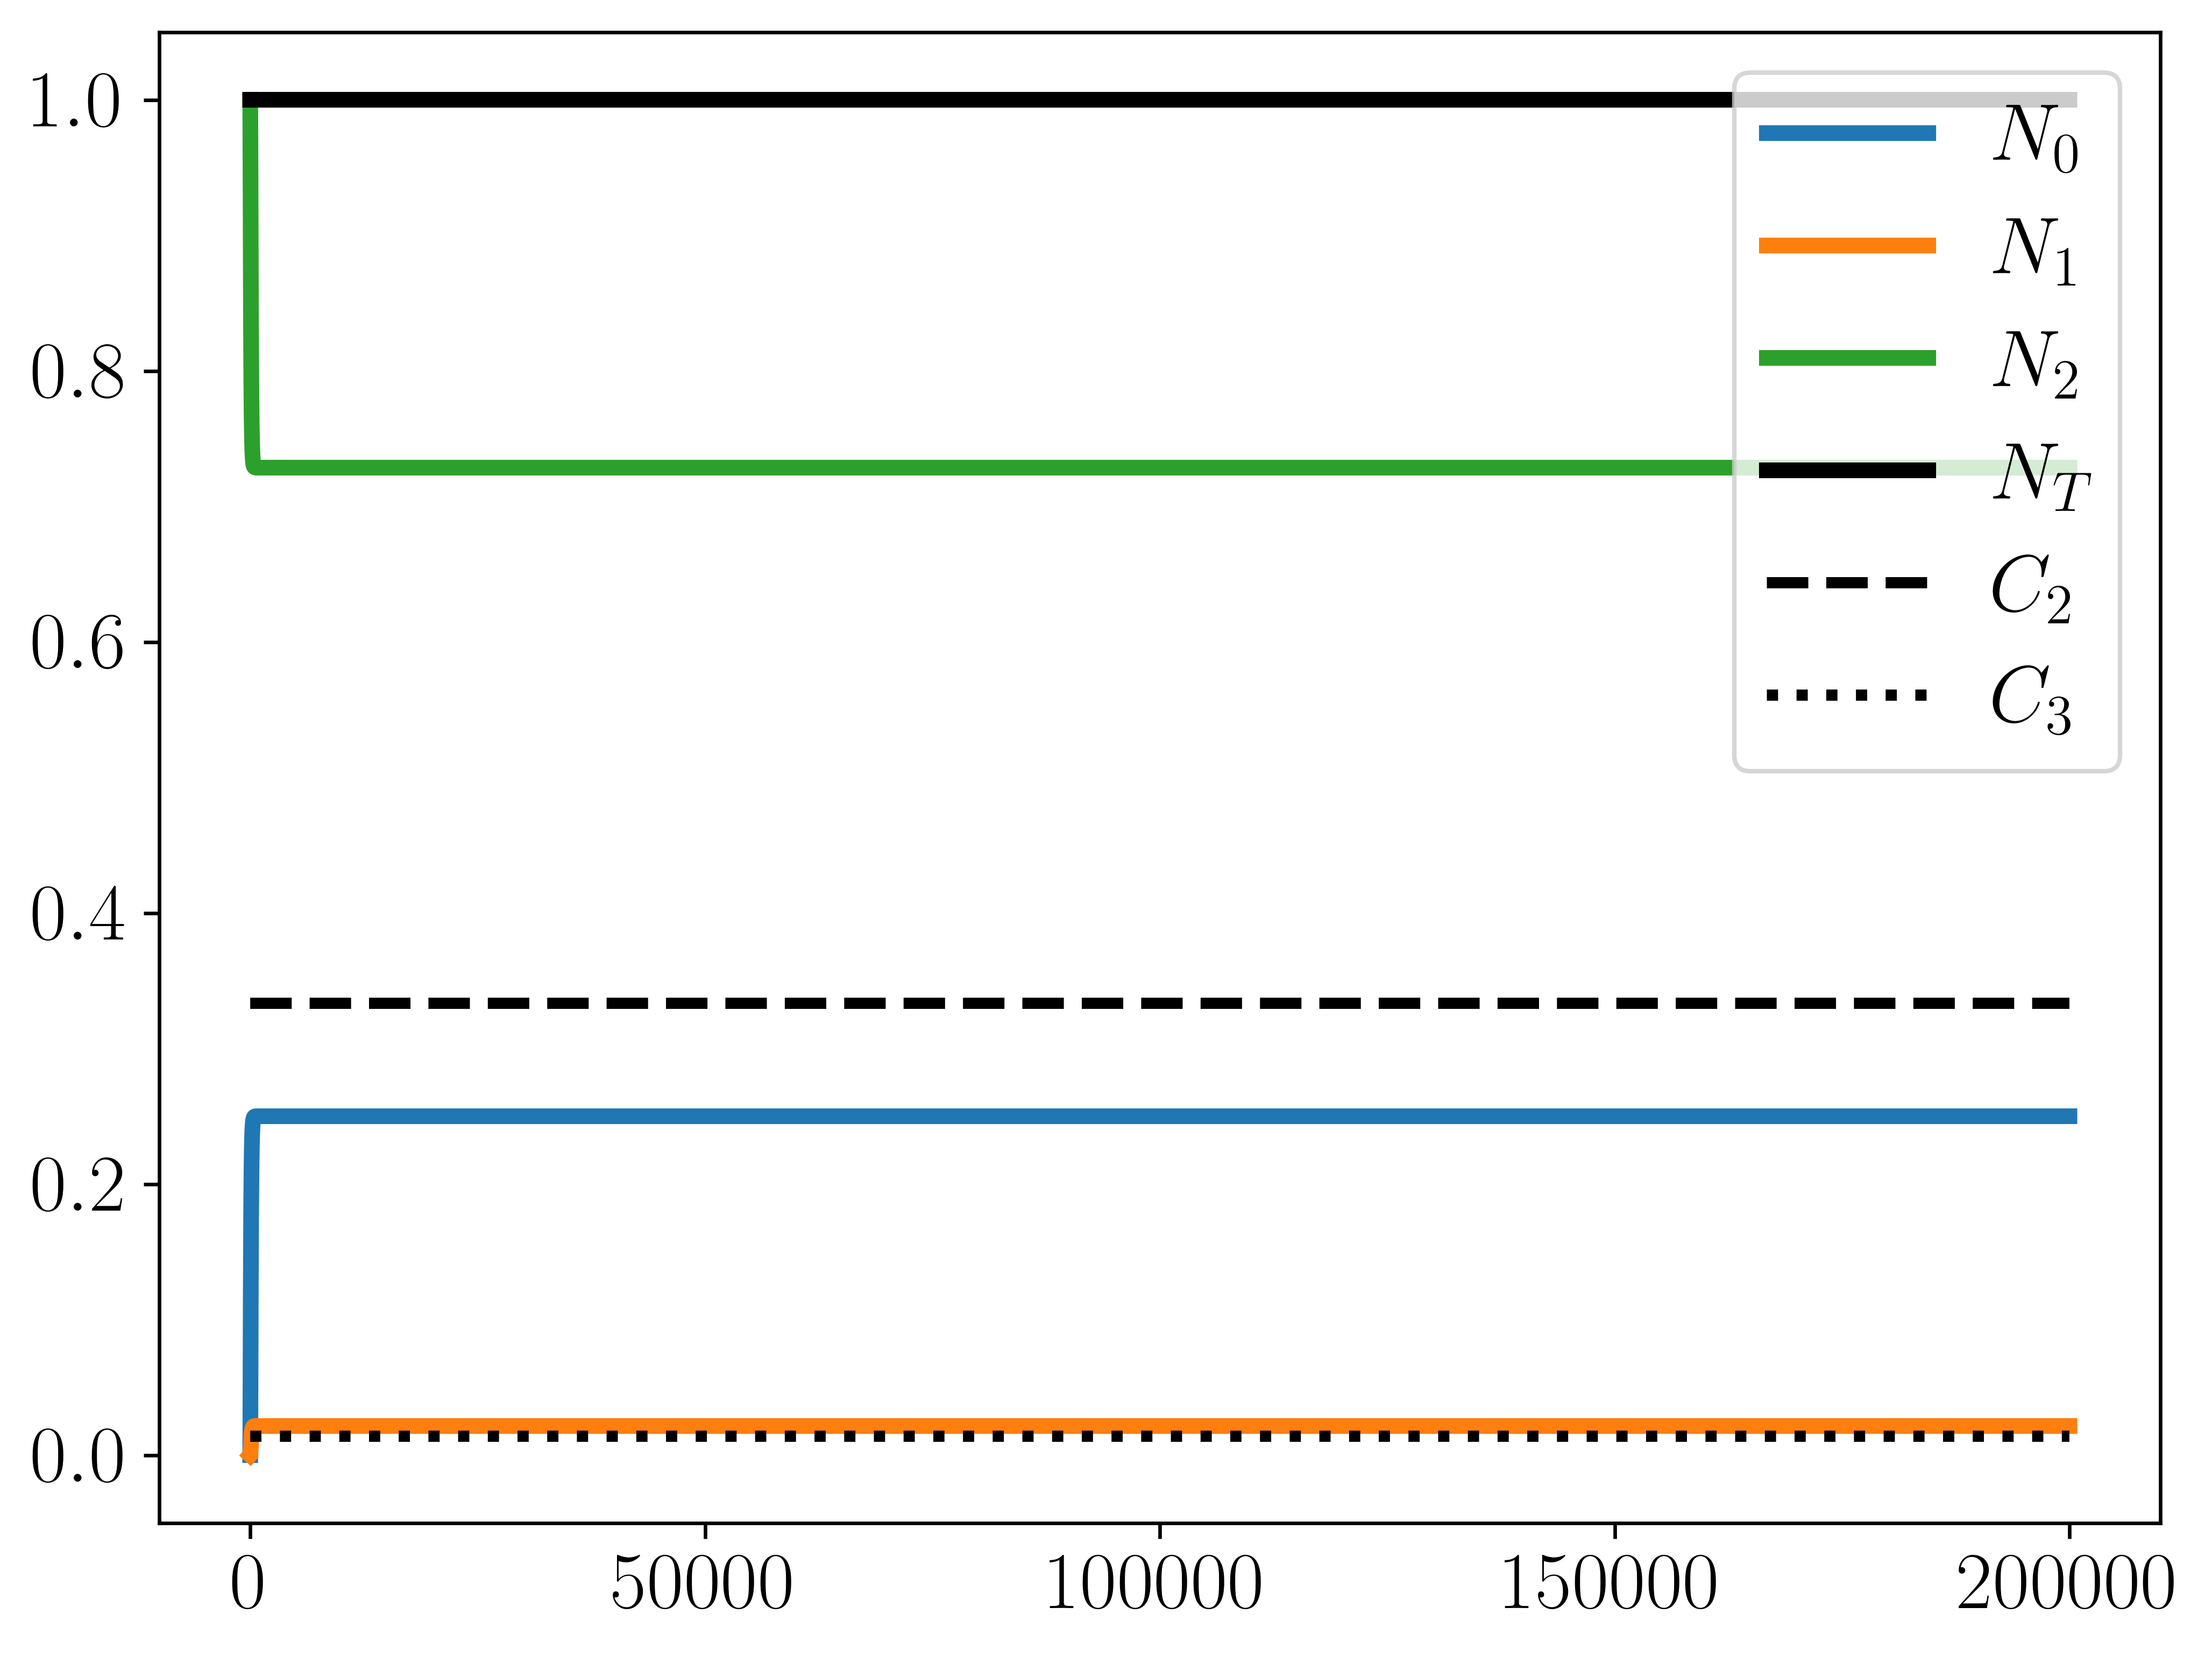

In [312]:
fig, ax= subplots(figsize=(8, 6), dpi=600)
ax.plot(t, N0, lw=3.5, label=L"N_0")
ax.plot(t, N1, lw=3.5, label=L"N_1")
ax.plot(t, N2, lw=3.5, label=L"N_2")
ax.plot(t, Nt, lw=3.5, linestyle="-", color="black", label=L"N_T")
ax.plot(t, C2, lw=2.5, linestyle="--", color="black", label=L"$C_2$")
ax.plot(t, C3, lw=2.5, linestyle=":", color="black", label=L"$C_3$")
# ax.plot(t, sol[1,:] + sol[6,:], label=L"1,6", lw=4)
# ax.plot(t, sol[3,:] + sqr't(3)*sol[8,:], label=L"3,8", lw4)
# ax.plot(t, sol[2,:] + sol[7,:], label=L"2,7", lw=4)
# ax.plot(t, (sol[1,:] .+ sol[6,:]).^2 + (sol[3,:] .+ sqrt(3)*sol[8,:]).^2 .+ (sol[2,:] .+ sol[7,:]).^2, label="tot", lw=4)
# ax.set_xscale("log")
ax.legend(loc="upper right")
display(fig)

Fourier Analysis

In [ ]:
n = length(N0)

Fs = 1/(t[2] - t[1])  # Replace with your sampling frequency (Hz)

# Preprocess data
N0_detrend = N0 .- mean(N0)
window = 0.5 .* (1 .- cos.(2π .* (0:n-1) ./ (n-1)))
N0_windowed = N0_detrend .* window

# Compute FFT

fft_N0 = fft(N0)
mag = abs.(fft_N0)

# One-sided spectrum adjustment
if n % 2 == 0
    mag_one_sided = mag[1:(n÷2 + 1)]
    mag_one_sided[2:end-1] .*= 2
else
    mag_one_sided = mag[1:((n+1) ÷ 2)]
    mag_one_sided[2:end] .*= 2
end

# Frequency axis
freq = Fs .* (0:(length(mag_one_sided)-1)) ./ n

In [ ]:

fig, ax = subplots(figsize=(8, 4), dpi=600)
plot(freq[2:end]./g, mag_one_sided[2:end],  label="FFT amplitude", lw=2.5)
argmax(sample)
xlim(0,1)
xlabel(L"Frequency $(\omega g)$")
ylabel(L"|Y(f)|")
legend()
tight_layout()
display(fig)

Map out mean field phase diagram 

In [ ]:
# Parameter setup
η_vals = range(0.1*g, 1.5*g, length=41)
φ_vals = range(-π, π, length=41)
# Δ_vals = range(-1.0*g, 1.0*g, length=41)

# Preallocate variance and mean arrays
var_N0 = zeros(length(φ_vals), length(η_vals))
var_N1 = zeros(length(φ_vals), length(η_vals))
var_N2 = zeros(length(φ_vals), length(η_vals))
var_ax = zeros(length(φ_vals), length(η_vals))
var_ap = zeros(length(φ_vals), length(η_vals))
var_argcav = zeros(length(φ_vals), length(η_vals))


mean_N0 = zeros(length(φ_vals), length(η_vals))
mean_N1 = zeros(length(φ_vals), length(η_vals))
mean_N2 = zeros(length(φ_vals), length(η_vals))
mean_ax = zeros(length(φ_vals), length(η_vals))
mean_ap = zeros(length(φ_vals), length(η_vals))
mean_argcav = zeros(length(φ_vals), length(η_vals))


# coherence arrays
mean_rho01 = zeros(length(φ_vals), length(η_vals))
var_rho01  = zeros(length(φ_vals), length(η_vals))
mean_rho02 = zeros(length(φ_vals), length(η_vals))
var_rho02  = zeros(length(φ_vals), length(η_vals))
mean_rho12 = zeros(length(φ_vals), length(η_vals))
var_rho12  = zeros(length(φ_vals), length(η_vals))
# --------------------------------------------------

# Steady-state window: last 40% of the time series
total_pts = length(t_list)
ss_start = round(Int, 0.6 * total_pts):total_pts

# Loop over φ and η
for (i, φ_val) in enumerate(φ_vals)
    for (j, η_val) in enumerate(η_vals)
        # Update parameters and initial condition
        params = (0.1g, 0.1*g, g, φ_val, Δ, κ, η_val)
        prob = ODEProblem(coupled_eqs!, u0, (0.0, tend), params)

        # Solve
        sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-6, abstol=1e-6)



        # Extract steady-state data
        N0_ss =  1/3 .- sol[3,ss_start] + 1/sqrt(3) .* sol[8,ss_start];
        N1_ss = 1/3 .+ sol[3,ss_start] + 1/sqrt(3) .* sol[8,ss_start];
        N2_ss = 1/3 .- 2/sqrt(3) .* sol[8,:];
        ax_ss = sol[end-1,ss_start]
        ap_ss = sol[end,ss_start]
        argcav_ss = atan.(ap_ss, ax_ss)  # Argument of the cavity field

        
        λ1_ss = sol[1, ss_start]
        λ2_ss = sol[2, ss_start]
        λ4_ss = sol[4, ss_start]
        λ5_ss = sol[5, ss_start]
        λ6_ss = sol[6, ss_start]
        λ7_ss = sol[7, ss_start]

        # --- build coherences in SS window
        rho01_ss = @. (λ1_ss + im*λ2_ss) / 2
        rho02_ss = @. (λ6_ss + im*λ7_ss) / 2
        rho12_ss = @. (λ4_ss + im*λ5_ss) / 2
    
        # --- record mean and variance of the absolute value
        mean_rho01[i,j] = mean(abs.(rho01_ss))
        var_rho01[i,j]  = var(abs.(rho01_ss))
    
        mean_rho02[i,j] = mean(abs.(rho02_ss))
        var_rho02[i,j]  = var(abs.(rho02_ss))
    
        mean_rho12[i,j] = mean(abs.(rho12_ss))
        var_rho12[i,j]  = var(abs.(rho12_ss))
        # Compute variances and mean
        var_N0[i, j] = var(N0_ss)
        var_N1[i, j] = var(N1_ss)
        var_N2[i, j] = var(N2_ss)
        var_ax[i, j] = var(ax_ss)
        var_ap[i, j] = var(ap_ss)
        var_argcav[i, j] = var(argcav_ss)

        # Compute means
        mean_N0[i,j] = mean(N0_ss)
        mean_N1[i,j] = mean(N1_ss)
        mean_N2[i,j] = mean(N2_ss)
        mean_ax[i,j] = mean(ax_ss)
        mean_ap[i,j] = mean(ap_ss)
        mean_argcav[i,j] = mean(argcav_ss)
    end
end

In [539]:
minimum(mean_N1)

-0.2553451361311773

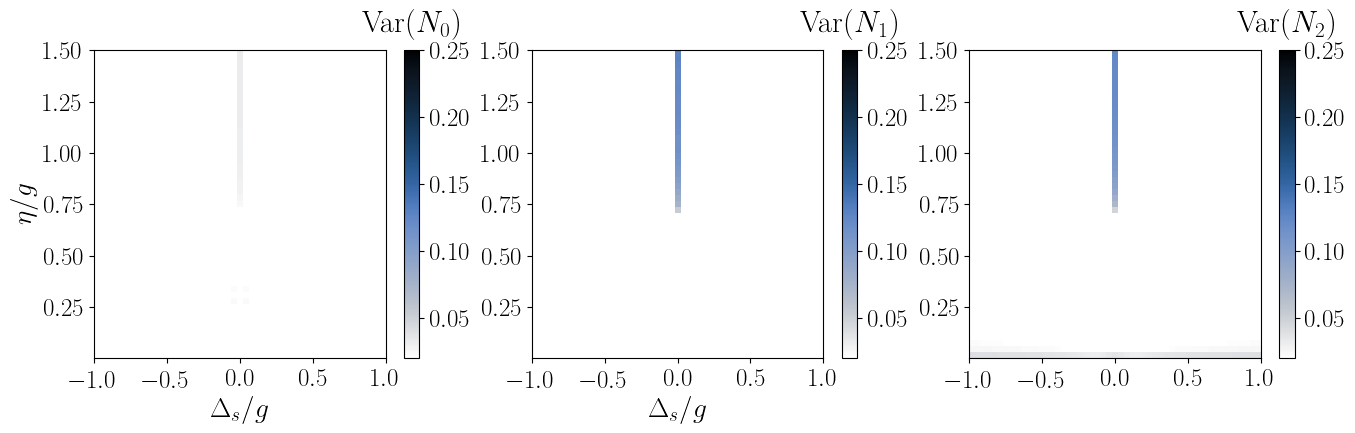

In [535]:
"""
Plot the variance phase diagram for a given N_i.

"""
# x = φ_vals./π
y = η_vals./g
x = Δ_vals./g
clims = (0.02, 0.25) 
cmap = oslo.reversed()

xtick_locs = [-1.0, -0.5, 0.0, 0.5, 1.0]  # x = φ/π
xtick_labels = [L"-\pi", L"-\pi/2", L"0", L"\pi/2", L"\pi"]


fig, axs = subplots(1, 3, figsize=(16, 4))


im1 = axs[1].imshow((var_N0)',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=cmap, clim = clims)     
axs[1].set_ylabel(L"\eta/g")
#axs[1].set_xlabel(L"\varphi/\pi")
axs[1].set_xlabel(L"\Delta_s/g")
# axs[1].set_xticks(xtick_locs)
# axs[1].set_xticklabels(xtick_labels)


im2 = axs[2].imshow((var_N1)',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=cmap, clim=clims)     
# axs[2].set_ylabel(L"\eta/g")
# axs[2].set_xlabel(L"\varphi/\pi")
axs[2].set_xlabel(L"\Delta_s/g")
# axs[2].set_xticks(xtick_locs)
# axs[2].set_xticklabels(xtick_labels)

im3 = axs[3].imshow((var_N2)',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=cmap, clim=clims)     
# axs[3].set_ylabel(L"\eta/g")
# axs[3].set_xlabel(L"\varphi/\pi")
axs[1].set_xlabel(L"\Delta_s/g")
# axs[3].set_xticks(xtick_locs)
# axs[3].set_xticklabels(xtick_labels)

cbar1 = colorbar(im1, ax=axs[1])
cbar2 = colorbar(im2, ax=axs[2])
cbar3 = colorbar(im3, ax=axs[3])
#Set colorbar label as the variance of N1 and N2, horizontally aligned on top of the colorbar
cbar1.ax.set_title(L"\mathrm{Var}(N_0)", pad=13)
cbar2.ax.set_title(L"\mathrm{Var}(N_1)", pad=13)
cbar3.ax.set_title(L"\mathrm{Var}(N_2)", pad=13)

# cbar1.ax.set_title(L"\langle N_0\rangle", pad=13)
# cbar2.ax.set_title(L"\langle N_1\rangle", pad=13)
# cbar3.ax.set_title(L"\langle N_2\rangle", pad=13)
display(fig)
# savefig("var_N0_N1_N2.pdf", bbox_inches="tight", dpi=600)

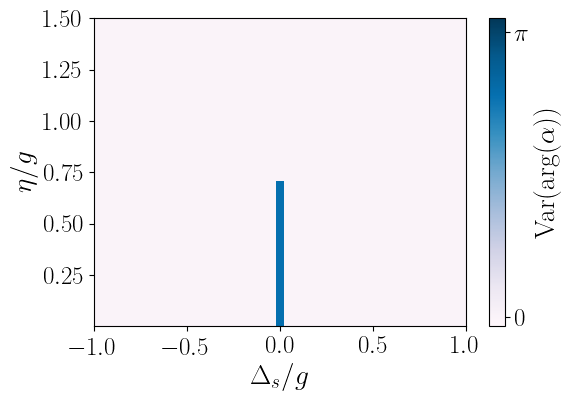

In [536]:
""" 

Plot other quantities of possible interest 

"""


#x = φ_vals./π
y = η_vals./g
x = Δ_vals./g

xtick_locs = [-1.0, -0.5, 0.0, 0.5, 1.0]  # x = φ/π
xtick_labels = [L"-\pi", L"-\pi/2", L"0", L"\pi/2", L"\pi"]


fig, axs = subplots( figsize=(6, 4))


im1 = axs.imshow((var_argcav)',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",    
                     aspect="auto", cmap="PuBu", vmin=-0.10, vmax=pi+0.15)     
axs.set_ylabel(L"\eta/g")
#axs.set_xlabel(L"\varphi/\pi")
axs.set_xlabel(L"\Delta_s/g")
# axs.set_xticks(xtick_locs)
# axs.set_xticklabels(xtick_labels)
cbar = colorbar(im1, ax=axs, label=L"\mathrm{Var}(\arg(\alpha))")
# cbar.set_ticks([-pi, -pi/2, 0, pi/2, pi])
# cbar.set_ticklabels([L"-\pi", L"-\pi/2", L"0", L"\pi/2", L"\pi"])
cbar.set_ticks([0, pi])
cbar.set_ticklabels([L"0", L"\pi"])
display(fig)
# savefig("../figs/spin1/var_argcav.pdf", bbox_inches="tight", dpi=600)

In [ ]:
# preallocate visibility arrays (one entry per η)

V_N0 = zeros(length(η_vals))
V_N1 = zeros(length(η_vals))
V_N2 = zeros(length(η_vals))

for j in eachindex(η_vals)
    # populations at fixed η_j across all φ
    y0 = mean_N0[:, j]
    y1 = mean_N1[:, j]
    y2 = mean_N2[:, j]

    # compute visibility
    V_N0[j] = (maximum(y0) - minimum(y0)) / (maximum(y0) + minimum(y0))
    V_N1[j] = (maximum(y1) - minimum(y1)) / (maximum(y1) + minimum(y1))
    V_N2[j] = (maximum(y2) - minimum(y2)) / (maximum(y2) + minimum(y2))
end


A1_N1 = zeros(length(η_vals))
A1_N2 = zeros(length(η_vals))
A1_N0 = zeros(length(η_vals))

for j in eachindex(η_vals)
    Y1 = mean_N1[:, j] .- mean(mean_N1[:, j])   # zero-mean in φ
    Y2 = mean_N2[:, j] .- mean(mean_N2[:, j])   # zero-mean in φ
    Y0 = mean_N0[:, j] .- mean(mean_N0[:, j])   # zero-mean in φ

    F1 = fft(Y1)
    F2 = fft(Y2)
    F0 = fft(Y0)
    A1_N1[j] = 2*abs(F1[2]) / length(φ_vals)    
    A1_N2[j] = 2*abs(F2[3]) / length(φ_vals)    
    A1_N0[j] = 2*abs(F0[4]) / length(φ_vals)    
end


In [ ]:
#Pick three colors from a colormap
colors = [lipari(0.2), lipari(0.5), lipari(0.8)]

fig, ax = subplots(figsize=(8, 6), dpi=600)
plot(η_vals ./ g, V_N0,lw=4, color=colors[1], label=L"V_0")
plot(η_vals ./ g, V_N1,lw=4, color=colors[2], label=L"V_1")
plot(η_vals ./ g, V_N2,lw=4, color=colors[3], label=L"V_2")
plot(η_vals ./g, [ mean(mean_N0[:, j]) for j in eachindex(η_vals) ], lw=3, ls=":", color=colors[1], label = L"\langle N_0 \rangle")
plot(η_vals ./g, [ mean(mean_N1[:, j]) for j in eachindex(η_vals) ], lw=3, ls=":", color=colors[2], label = L"\langle N_1 \rangle")
plot(η_vals ./g, [ mean(mean_N2[:, j]) for j in eachindex(η_vals) ], lw=3, ls=":", color=colors[3], label = L"\langle N_2 \rangle")
# plot(η_vals ./ g, A1_N1,lw=4, linestyle="--", color="black", label=L"A_1")
# plot(η_vals ./ g, A1_N2,lw=4, linestyle=":", color="black", label=L"A_2")
# plot(η_vals ./ g, A1_N0,lw=4, linestyle="-", color="black", label=L"A_0")

ax.set_xlabel(L"\eta/g")
ax.set_ylabel(L"V_i")
legend()
display(fig)

In [ ]:
V_12 = zeros(length(η_vals))
A1_12 = zeros(length(η_vals))
A1_01 = zeros(length(η_vals))
A1_02 = zeros(length(η_vals))

for j in eachindex(η_vals)
    # get the φ–series of the two levels
    N1_vsφ = mean_N1[:, j]
    N2_vsφ = mean_N2[:, j]
    N0_vsφ = mean_N0[:, j]

    # define the normalized difference F(φ)
    F = @. (N2_vsφ - N1_vsφ) / (N2_vsφ + N1_vsφ)
    F20 = @. (N2_vsφ - N0_vsφ) / (N2_vsφ + N0_vsφ)
    F10 = @. (N1_vsφ - N0_vsφ) / (N1_vsφ + N0_vsφ)
    # --- visibility of F(φ) ---
    Fmax, Fmin = maximum(F), minimum(F)
    Fmax20, Fmin20 = maximum(F20), minimum(F20)
    Fmax10, Fmin10 = maximum(F10), minimum(F10)
    V_12[j] = (Fmax - Fmin) / (Fmax + Fmin)
    # V_20[j] = (Fmax20 - Fmin20) / (Fmax20 + Fmin20)
    # V_10[j] = (Fmax10 - Fmin10) / (Fmax10 + Fmin10)


    # --- first‐harmonic amplitude of F(φ) ---
    F0 = F .- mean(F)
    F1 = F10 .- mean(F10)
    F2 = F20 .- mean(F20)
    Ff = fft(F0)
    Ff1 = fft(F1)
    Ff2 = fft(F2)
    A1_12[j] = 2 * abs(Ff[2]) / length(F0)
    A1_02[j] = 2 * abs(Ff2[3]) / length(F0)
    A1_01[j] = 2 * abs(Ff1[4]) / length(F0)
end

fig, ax = subplots(figsize=(8, 6), dpi=600)
# plot(η_vals ./ g, V_12,lw=4, color=colors[1], label=L"V_{12}")
plot(η_vals ./ g, A1_12,lw=4, label=L"A_{12}", color="navy", alpha=0.9)
plot(η_vals ./ g, A1_02,lw=4, label=L"A_{02}", color="navy", alpha=0.5)
plot(η_vals ./ g, A1_01,lw=4, label=L"A_{01}", color="navy", alpha=0.2)
plot(η_vals ./g, [ mean(mean_N0[:, j]) for j in eachindex(η_vals) ], lw=4, color=colors[1], label = L"\langle N_0 \rangle")
plot(η_vals ./g, [ mean(mean_N1[:, j]) for j in eachindex(η_vals) ], lw=4, color=colors[2], label = L"\langle N_1 \rangle")
plot(η_vals ./g, [ mean(mean_N2[:, j]) for j in eachindex(η_vals) ], lw=4,color=colors[3], label = L"\langle N_2 \rangle")
ax.set_xlabel(L"\eta/g")

legend()
ax.set_ylim(-0.01,0.6)
display(fig)

In [ ]:
η_vals[argmax(A1_12)+1]

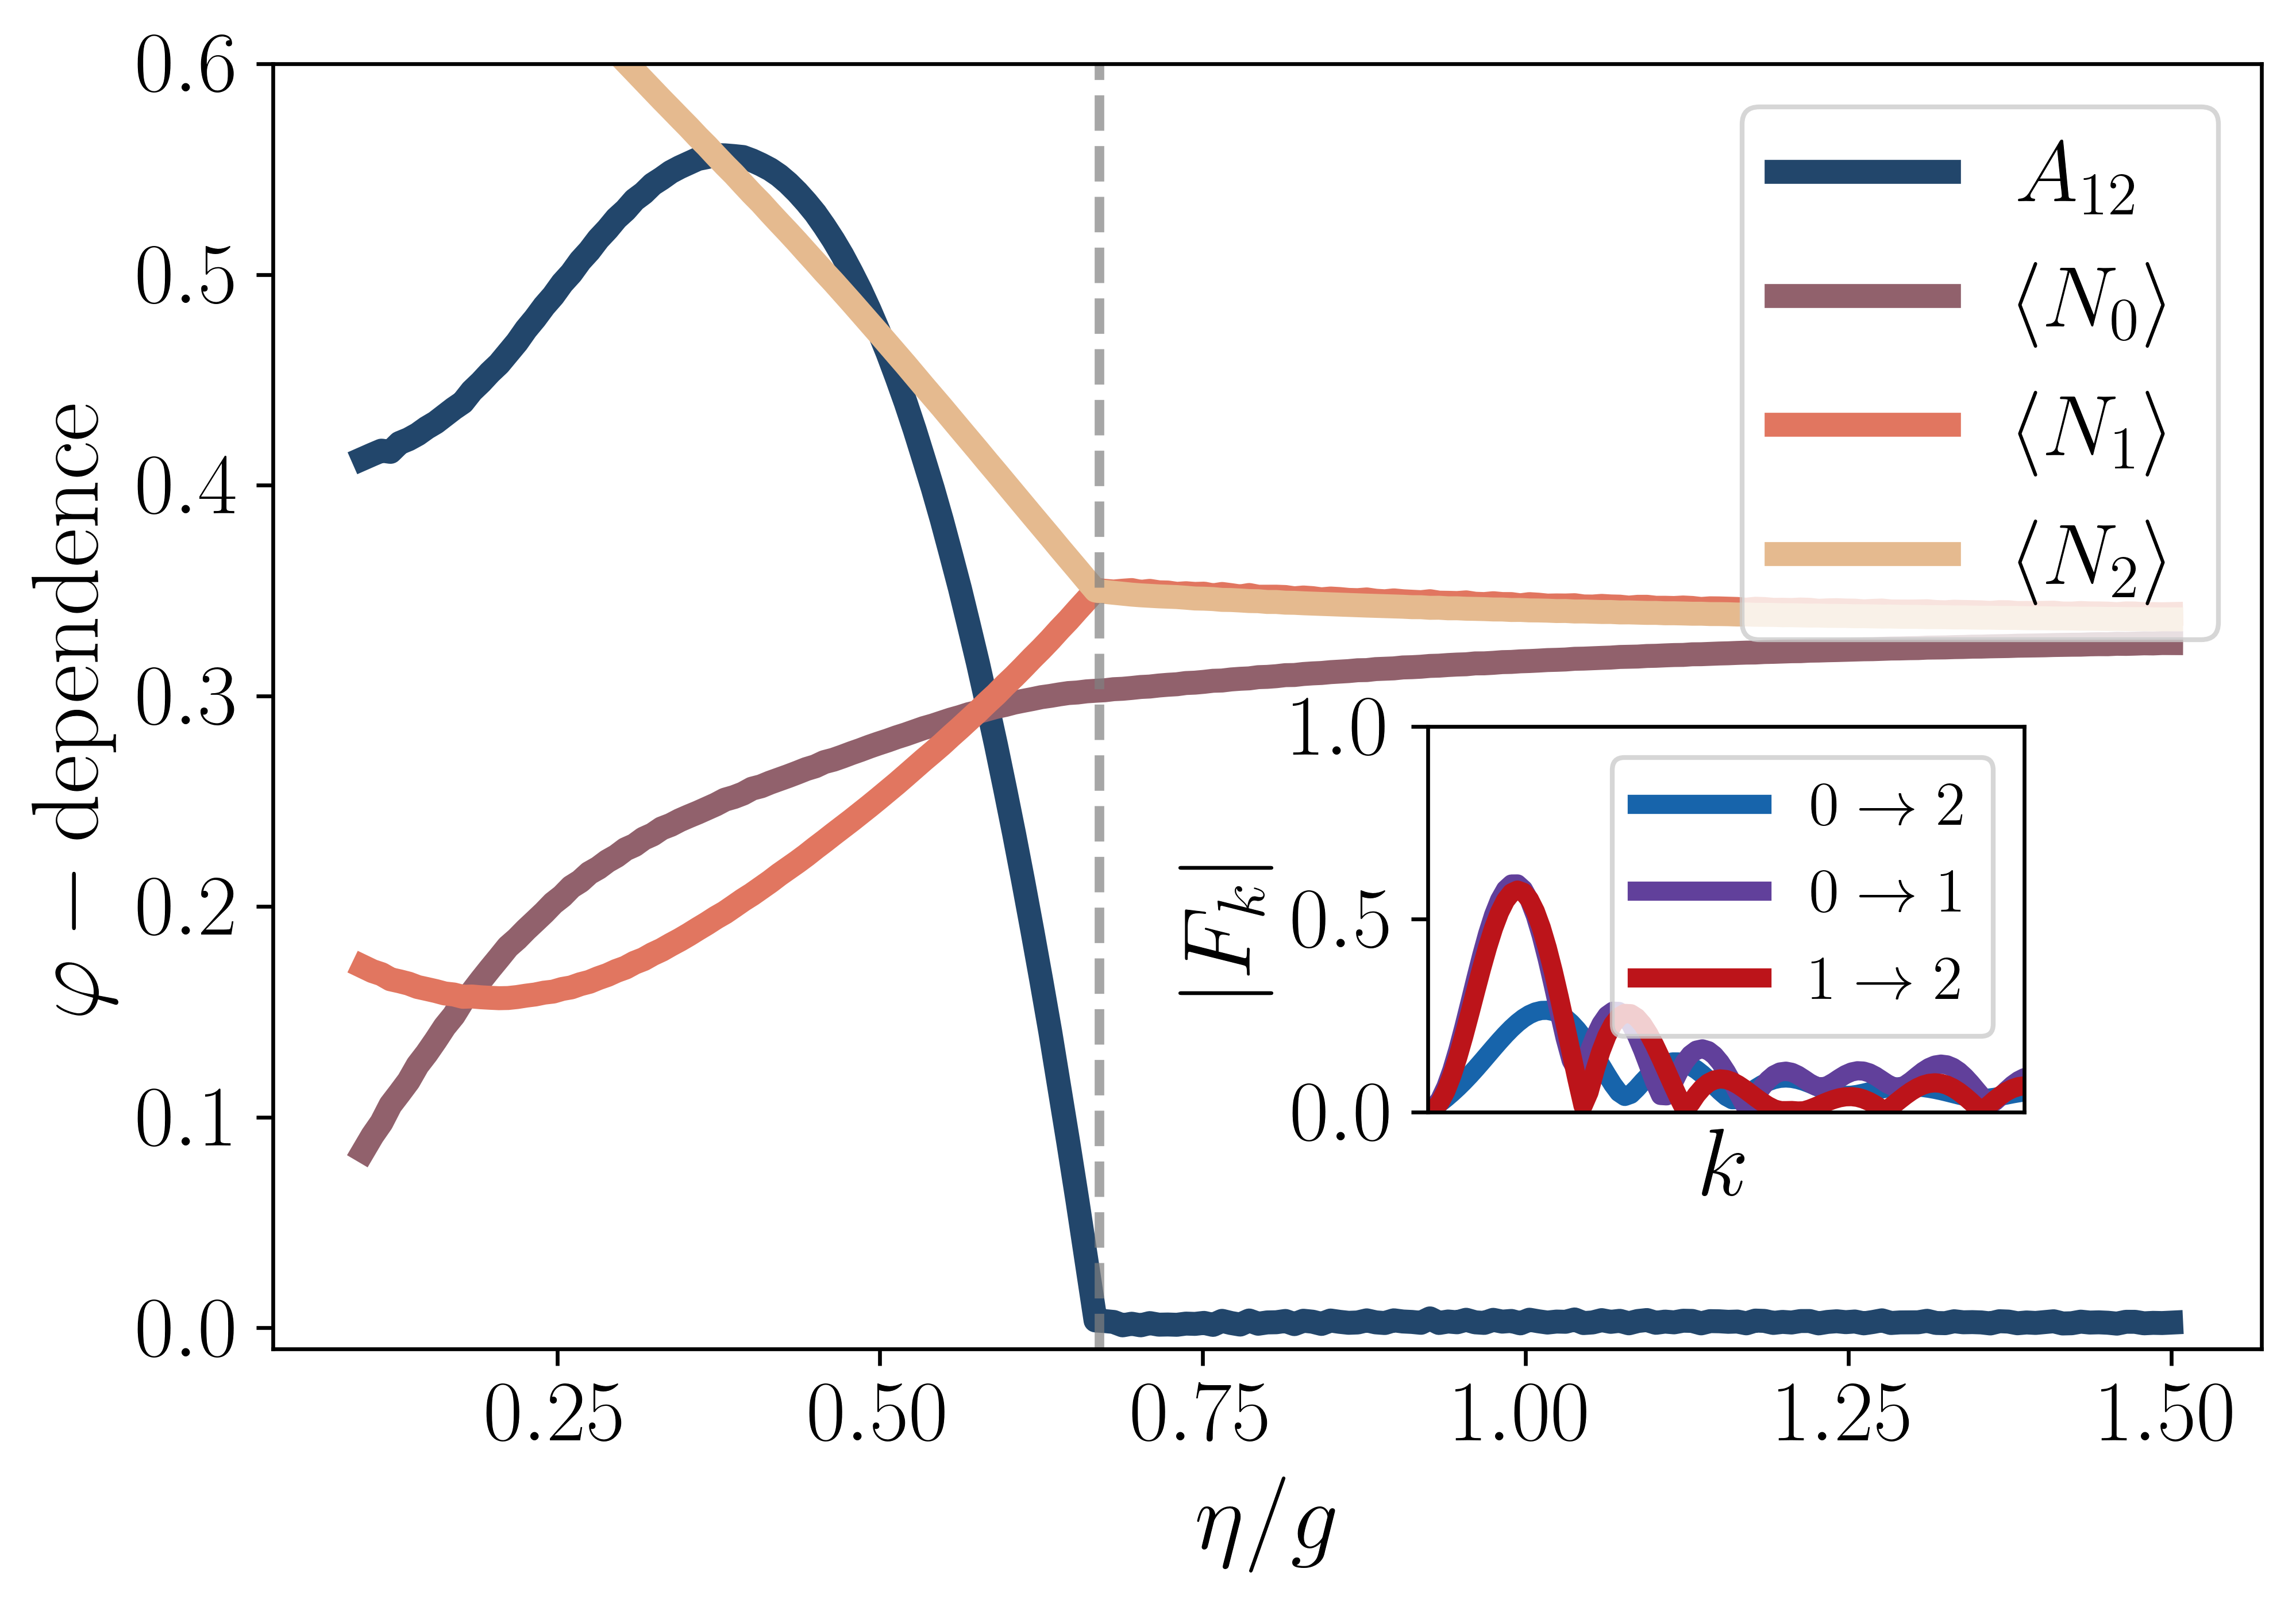

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [2891]:
@pyimport mpl_toolkits.axes_grid1.inset_locator as il
# 1) find the φ-slice where A1_12 peaks
j_peak = argmax(A1_12)
η_peak = η_vals[j_peak] / g

# 2) build F(φ) at that η and its FFT
N1_vsφ = mean_N1[:, j_peak]
N2_vsφ = mean_N2[:, j_peak]
F       = @. (N2_vsφ - N1_vsφ) / (N2_vsφ + N1_vsφ)
F0      = F .- mean(F)
Ff      = fft(F0)
# k       = collect(0:length(Ff)-1)

# 3) main figure
fig, ax = subplots(figsize=(7,5), dpi=600)
colors = [lipari(0.15),lipari(0.45), lipari(0.65), lipari(0.85)]
ax[:plot](η_vals ./ g, A1_12, lw=5, label=L"A_{12}", color=colors[1])
ax[:plot](η_vals ./ g, [ mean(mean_N0[:, j]) for j in eachindex(η_vals) ], lw=5, color=colors[2], label=L"\langle N_0\rangle")
ax[:plot](η_vals ./ g, [ mean(mean_N1[:, j]) for j in eachindex(η_vals) ], lw=5, color=colors[3], label=L"\langle N_1\rangle")
ax[:plot](η_vals ./ g, [ mean(mean_N2[:, j]) for j in eachindex(η_vals) ], lw=5, color=colors[4], label=L"\langle N_2\rangle")
ax[:axvline](0.67, lw=2, ls="--", color="grey", alpha=0.7)


ax[:set_xlabel](L"\eta/g")
ax[:set_ylabel](L"\varphi-\mathrm{dependence}")
ax[:set_ylim](-0.01, 0.6)
ax[:legend](loc="upper right")

# 4) inset via the toolkit importer
axins = il.inset_axes(ax, "30%", "30%", loc="lower right", borderpad=2.75)

# plot the FFT amplitudes in the inset
Reds = cmap.Colormap("colorbrewer:reds").to_mpl()
Blues = cmap.Colormap("colorbrewer:blues").to_mpl()
Purples = cmap.Colormap("colorbrewer:purples").to_mpl()
colorinset1 = [Reds(0.25), Reds(0.5), Reds(0.8)]
colorinset2 = [Blues(0.25), Blues(0.5), Blues(0.8)]
colorinset3 = [Purples(0.25), Purples(0.5), Purples(0.8)]

# axins[:plot](k_vals, amps02_3, lw=3, ls="--", color=colorinset2[1],  label=L"\eta=0.1g")
axins[:plot](k_vals, amps02_1, lw=4, color=colorinset2[3], label=L"0\rightarrow2" )#label=L"\eta=0.37g")
# axins[:plot](k_vals, amps01_3, lw=3, ls="--", color=colorinset3[1],  label=L"\eta=0.1g")
axins[:plot](k_vals, amps01_1, lw=4, color=colorinset3[3], label=L"0\rightarrow1" )
# axins[:plot](k_vals, amps12_3, lw=3, ls="--", color=colorinset1[1],  label=L"\eta=0.1g")
axins[:plot](k_vals, amps12_1, lw=4, color=colorinset1[3], label=L"1\rightarrow2")
# axins[:plot](k_vals, amps12_2, lw=3, color=colorinset1[3])
# axins[:plot](k_vals, amps12_3, lw=3, color=colorinset1[1])
axins[:set_xlim](0, 100)
axins[:set_ylim](0, 1)
axins[:set_xlabel](L"k")
axins[:set_ylabel](L"|F_k|")
axins[:set_xticks]([])
axins[:legend](loc="upper right",fontsize=13)

tight_layout()
# savefig("../figs/spin1/phase-pop-fourier.pdf", bbox_inches="tight", dpi=600)
display(fig)

In [ ]:
# 1) identify the three drive‐strengths
j_peak   = argmax(A1_12)
η_list   = (η_vals[j_peak], g, 0.1g)

# 2) prepare φ‐grid, steady‐state slice, padding
N_fine   = 3000
φ_fine   = range(-π, π; length=N_fine)
ss       = round(Int, 0.7*length(t_list)):length(t_list)
Npad     = 40000
k_max    = Npad ÷ 2

# 3) generic worker to return three spectra at a given η0
function compute_three_amps(η0)
  mean_N0_f = zeros(N_fine)
  mean_N1_f = zeros(N_fine)
  mean_N2_f = zeros(N_fine)

  for (i, φv) in enumerate(φ_fine)
    params = (0, 0, g, φv, Δ, κ, η0)
    prob   = ODEProblem(coupled_eqs!, u0, (0.0, tend), params)
    sol    = solve(prob, Tsit5(), saveat=t_list,
                    reltol=1e-6, abstol=1e-9)

    # reconstruct level populations in SS
    N0_ss = 1/3 .- sol[3,ss] .+ (1/√3).*sol[8,ss]
    N1_ss = 1/3 .+ sol[3,ss] .+ (1/√3).*sol[8,ss]
    N2_ss = 1/3 .- (2/√3).*sol[8,ss]

    mean_N0_f[i] = mean(N0_ss)
    mean_N1_f[i] = mean(N1_ss)
    mean_N2_f[i] = mean(N2_ss)
  end

  # form the three normalized‐difference signals
  F12     = @. (mean_N2_f - mean_N1_f) / (mean_N2_f + mean_N1_f)
  F02     = @. (mean_N2_f - mean_N0_f) / (mean_N2_f + mean_N0_f)
  F01     = @. (mean_N1_f - mean_N0_f) / (mean_N1_f + mean_N0_f)

  # zero‐mean each
  F12_0   = F12 .- mean(F12)
  F02_0   = F02 .- mean(F02)
  F01_0   = F01 .- mean(F01)

  # zero-pad & FFT
  pad12   = vcat(F12_0, zeros(Npad - N_fine))
  pad02   = vcat(F02_0, zeros(Npad - N_fine))
  pad01   = vcat(F01_0, zeros(Npad - N_fine))

  Ff12    = fft(pad12)
  Ff02    = fft(pad02)
  Ff01    = fft(pad01)

  # take positive‐k bins 1…k_max, normalize by N_fine
  amps12  = 2 .* abs.(Ff12[2:(k_max+1)]) ./ N_fine
  amps02  = 2 .* abs.(Ff02[2:(k_max+1)]) ./ N_fine
  amps01  = 2 .* abs.(Ff01[2:(k_max+1)]) ./ N_fine

  return amps12, amps02, amps01
end

# 4) compute for each η in η_list
amps12_1, amps02_1, amps01_1 = compute_three_amps(η_list[1])   # η_peak
amps12_2, amps02_2, amps01_2 = compute_three_amps(η_list[2])   # η = g
amps12_3, amps02_3, amps01_3 = compute_three_amps(η_list[3])   # η = 0.1g

In [ ]:
fig = figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection="3d")

# Parametric plot with time-color coding
sc = ax.scatter(N0, N1, N2, c=t, cmap="Blues", s=100)


# Formatting
ax.set_xlabel(L"N_0")
ax.set_ylabel(L"N_1")
ax.set_zlabel(L"N_2")
ax.set_xticks([0,1/2,  1])
ax.set_yticks([0, 1/2,  1])
ax.set_zticks([0, 1/2,  1])

# Set viewing angle (adjust these numbers as needed)
ax.view_init(elev=25, azim=40)

tight_layout()
display(fig)

In [ ]:
# Create offsets to separate populations vertically
offset = 1.0  # Adjust this to control spacing between lanes
N0_shifted = N0 .+ 0*offset
N1_shifted = N1 .+ 1*offset
N2_shifted = N2 .+ 2*offset


colors = [lajolla(0.2), lajolla(0.5), lajolla(0.8)]

fig, ax = subplots(figsize=(6,4))

# Plot each population in its lane
ax.plot(t.*g, N0_shifted, lw=3, label=L"N_0", color=colors[1])
# ax.plot(t.*g, 1/3*ones(length(t)), lw=3, linestyle="--", color="black", alpha=0.25)
# ax.plot(t.*g, 4/3*ones(length(t)), lw=3, linestyle="--", color="black", alpha=0.25)
# ax.plot(t.*g, 7/3*ones(length(t)), lw=3, linestyle="--", color="black", alpha=0.25)
ax.plot(t.*g, N1_shifted, lw=3, label=L"N_1", color=colors[2])
ax.plot(t.*g, N2_shifted, lw=3, label=L"N_2", color=colors[3])

# Add horizontal separators between lanes
for y in [offset-0.25, 2*offset-0.25]
    ax.axhline(y, color="k", linestyle="--", alpha=0.3, lw=2.5)
end

# Format y-axis to show population labels instead of offsets
yticks_pos = [0*offset+0.25, 1*offset+0.25, 2*offset+0.25]
yticks_labels = [L"N_0", L"N_1", L"N_2"]
ax.set_yticks(yticks_pos)
ax.set_yticklabels(yticks_labels)

# Add physical population values on right axis 
# ax2 = ax.twinx()
# ax2.set_ylim(ax.get_ylim())  # Match main axis limits
# ax2.set_yticks([0*offset+0.55, 1*offset+0.35, 2*offset+0.2])
# ax2.set_yticklabels([L"1/3", L"1/3", L"1/3"])
# Labels and legend
ax.set_xlabel(L"Time $\,gt$")
# ax.legend(loc="upper right")

# Optional: Add fill between curves for visual clarity
ax.fill_between(t.*g, N0_shifted, 0*offset, alpha=0.15, color=colors[1])
ax.fill_between(t.*g, N1_shifted, 1*offset, alpha=0.15, color=colors[2])
ax.fill_between(t.*g, N2_shifted, 2*offset, alpha=0.15, color=colors[3])

display(fig)

Correlation measures and relative population features

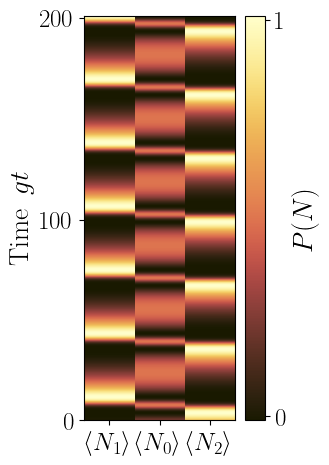

In [121]:
# Create composite matrix for heatmap (N1 | N0 | N2)
heatmap_data = [N1 N0 N2]

# Plot
fig, ax = subplots(figsize=(3.5, 5))
im1 = ax.imshow(heatmap_data, 
              aspect="auto",
              cmap=lajolla.reversed(), clim=(0, 1),
              interpolation="none",
              extent=[0.5, 3.5, t[1]*g, t[end]*g])

# Formatting
ax.set_xticks([1, 2, 3])
ax.set_xticklabels([L"\langle N_1\rangle", L"\langle N_0\rangle", L"\langle N_2\rangle"])
ax.set_ylabel(L"Time $\,gt$")
ax.set_yticks([0, 99, 199])
ax.set_yticklabels([0, 100, 200])
cbar = fig.colorbar(im1, label=L"P(N)")
cbar.set_ticks([0.01, 0.99])
cbar.set_ticklabels([L"0", L"1"])
tight_layout()

display(fig)
savefig("../figs_for_paper/fig1_4.svg", dpi=600, bbox_inches="tight")

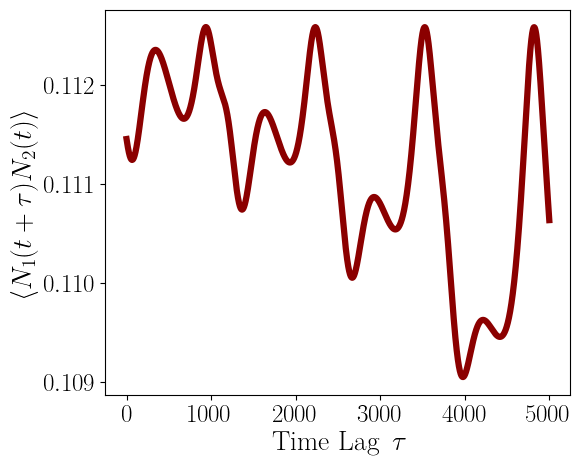

In [2879]:
function compute_correlation(N1, N2, τ_max)
    n = length(N1)
    τ_values = 0:τ_max
    correlations = zeros(length(τ_values))
    
    for (i, τ) in enumerate(τ_values)
        if τ >= n
            correlations[i] = NaN
            continue
        end
        # Compute mean product for valid time shifts
        valid_range = 1:(n - τ)
        correlations[i] = mean(N1[valid_range .+ τ] .* N2[valid_range])
    end
    
    (τ_values, correlations)
end

# Compute correlations (adjust τ_max as needed)
τ_max = Int64((length(N0)-1)/2)  # Maximum time lag to consider
τ_vals, corr = compute_correlation(N0, N1, τ_max)

# Plot
fig, ax = subplots(figsize=(6,5))
ax.plot(τ_vals, corr, lw=4.5, color="darkred")
ax.set_xlabel(L"Time Lag $\,\tau$")
ax.set_ylabel(L"$\langle N_1(t+\tau)N_2(t) \rangle$")
display(fig)

$g^2$ correlation function

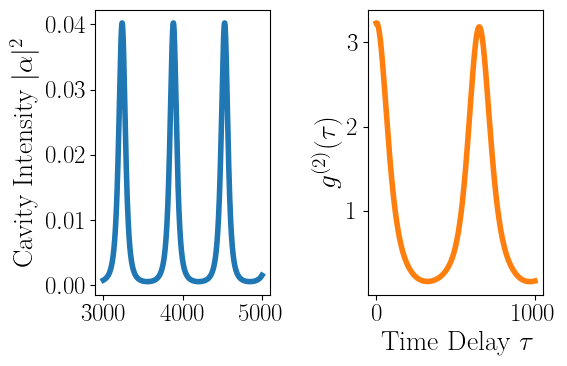

In [2881]:
# 1. Modified correlation function for g² calculation
function compute_g2_correlation(I::Vector{Float64}, τ_max::Int)
    n = length(I)
    τ_values = 0:τ_max
    correlations = zeros(length(τ_values))
    I_mean = mean(I)
    
    for (i, τ) in enumerate(τ_values)
        if τ >= n
            correlations[i] = NaN
            continue
        end
        valid_range = 1:(n - τ)
        correlations[i] = mean(I[valid_range .+ τ] .* I[valid_range]) / (I_mean^2)
    end
    
    τ_values, correlations
end

# 2. Cavity intensity analysis
function analyze_cavity(sol, t_list, τ_max; ss_frac=0.6)
    # Extract cavity field components
    α_re = sol[9,:]
    α_im = sol[10,:]
    
    # Compute intensity |α|²
    I = α_re.^2 .+ α_im.^2
    
    # Steady-state window
    ss_start = round(Int, ss_frac*length(t_list))
    I_ss = I[ss_start:end]
    t_ss = t_list[ss_start:end]
    
    # Compute g² correlation
    τ_vals, g2 = compute_g2_correlation(I_ss, τ_max)
    
    # Time scaling
    Δt = t_list[2] - t_list[1]
    τ_scaled = τ_vals .* Δt
    
    (τ_scaled, g2, I_ss, t_ss)
end

τ, g2, I_ss, t_ss = analyze_cavity(sol, t_list, 2000);

fig, ax = subplots(1,2, figsize=(6,4))
    
# Intensity timeseries

ax[1].plot(t_ss, I_ss, lw=4, color="C0")
ax[1].set_ylabel(L"Cavity Intensity $|\alpha|^2$")


# g² correlation
ax[2].plot(τ, g2, lw=4, color="C1")
ax[2].set_xlabel(L"Time Delay $\tau$")
ax[2].set_ylabel(L"$g^{(2)}(\tau)$")
# ax[2].set_ylim(0.5,1.5)
tight_layout()
display(fig)


Phase-dependence analysis of correlations

In [2882]:
# Parameter sweep over φ
phi_values = range(-π, π, length=150)
corr_matrix = zeros(length(τ_vals), length(phi_values))

for (j, phi) in enumerate(phi_values)
    # Rerun simulation with new phi
    params = (Δ1, Δ2, g, phi, Δ, κ, η)
    prob = ODEProblem(coupled_eqs!, u0, (0.0, tend), params)
    sol = solve(prob, Tsit5(), saveat=t_list)
    
    # Extract new N0, N1, N2
    N0_new = 1/3 .- sol[3,:] .+ (1/√3).*sol[8,:]
    N1_new = 1/3 .+ sol[3,:] .+ (1/√3).*sol[8,:]
    N2_new = 1/3 .- (2/√3).*sol[8,:]
    
    # Compute correlations
    _, corr_matrix[:,j] = compute_correlation(N1_new, N2_new, τ_max)
end


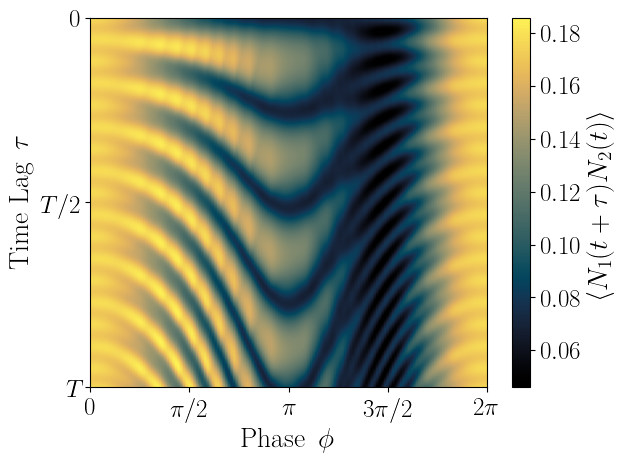

In [2883]:

# Plot φ-dependent correlations
fig, ax = subplots()
im1 = ax.imshow(corr_matrix, aspect="auto", 
              extent=[0, 2π, τ_max, 0],
              cmap=eclipse)
ax.set_xlabel(L"Phase $\,\phi$")
ax.set_ylabel(L"Time Lag $\,\tau$")
ax.set_yticks([0, τ_max/2, τ_max])
ax.set_yticklabels([L"0", L"T/2", L"T"])
ax.set_xticks([0, π/2, π, 3π/2, 2π])    
ax.set_xticklabels([L"0", L"\pi/2", L"\pi", L"3\pi/2", L"2\pi"])
cbar = fig.colorbar(im1, label=L"$\langle N_1(t+\tau)N_2(t) \rangle$")
# ax.annotate(L"\eta = %η$", xy=(0.5,0.5))
#savefig("../figs/spin1/correlationphasediag_phi.pdf", dpi=600)
display(fig)

In [ ]:
using DSP

# 1. Frequency Analysis 
function compute_dominant_frequency(signal, t; freq_threshold=1e-3)
    Δt = t[2] - t[1]
    n = length(signal)
    
    # Handle constant signals
    if all(signal .≈ signal[1])
        return NaN
    end
    
    # Detrend signal (remove DC offset)
    signal_detrend = signal .- mean(signal)
    
    # Apply window
    window = DSP.hanning(n)
    signal_win = signal_detrend .* window
    
    # Compute FFT
    fft_vals = fft(signal_win)
    freqs = fftfreq(n, 1/Δt)
    psd = abs.(fftshift(fft_vals)).^2
    freqs_shifted = fftshift(freqs)
    
    # Ignore DC and low frequencies
    pos_mask = (freqs_shifted .> freq_threshold)
    if !any(pos_mask)
        return NaN
    end
    
    dominant_idx = argmax(psd[pos_mask])
    dominant_freq = freqs_shifted[pos_mask][dominant_idx]
    
    dominant_freq
end

# 2. Cross-Correlation Function with Correct Windowing
function compute_correlation(N1, N2, τ_max)
    n = length(N1)
    τ_values = 0:τ_max
    correlations = zeros(length(τ_values))
    
    # Apply hanning window to both signals
    window = DSP.hanning(n)
    N1_win = N1 .* window
    N2_win = N2 .* window
    
    for (i, τ) in enumerate(τ_values)
        if τ >= n
            correlations[i] = NaN
            continue
        end
        valid_range = 1:(n - τ)
        correlations[i] = mean(N1_win[valid_range .+ τ] .* N2_win[valid_range])
    end
    
    (τ_values, correlations)
end

# 3. Parameter Scan Setup
ϕ_values = range(0, 2π, length=100)
T_ϕ = zeros(length(ϕ_values))
τ_peak_ϕ = zeros(length(ϕ_values))
τ_max = 1000  # Maximum time lag for correlation

# 4. Main Computation Loop
for (i, ϕ) in enumerate(ϕ_values)
    # Run simulation
    params = (Δ1, Δ2, g, ϕ, Δ, κ, η)
    prob = ODEProblem(coupled_eqs!, u0, (0.0, tend), params)
    sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-8)
    
    # Compute populations
    N1 = @. 1/3 + sol[3,:] + (1/√3)*sol[8,:]
    N2 = @. 1/3 - (2/√3)*sol[8,:]
    
    # Frequency analysis
    dominant_freq = compute_dominant_frequency(N1, t_list; freq_threshold=1e-12)
    # Safeguard against NaN
    if isnan(dominant_freq) || abs(dominant_freq) < 1e-12
        T_ϕ[i] = NaN
    else
        T_ϕ[i] = 1/abs(dominant_freq)
    end
    
    # Correlation analysis
    τ_vals, corr = compute_correlation(N1, N2, τ_max)
    τ_peak_ϕ[i] = τ_vals[argmax(corr)] * (t_list[2]-t_list[1])
end

In [ ]:
# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(12, 8))

# Top panel: Population dynamics for 3 phase values
ϕ_demo = [pi/2,ϕ_values[end]/2, 5.1] 
colors = [eclipse(0.1), eclipse(0.6), eclipse(0.9)] 

for (i, ϕ) in enumerate(ϕ_demo)
    # Run simulation
    params = (Δ1, Δ2, g, ϕ, Δ, κ, η)
    prob = ODEProblem(coupled_eqs!, u0, (0.0, tend), params)
    sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-8)
    
    # Compute populations
    N1 = @. 1/3 + sol[3,:] + (1/√3)*sol[8,:]
    N2 = @. 1/3 - (2/√3)*sol[8,:]
    
    # Plot with phase-specific colors
    ax1.plot(t_list, N1, color=colors[i], 
            label=L"$\phi = %$(round(ϕ, digits=2))$", lw=4)
    ax1.plot(t_list, N2, color=colors[i], linestyle="--", lw=4)
end

ax1.set_ylabel("Population")
ax1.legend(ncol=3, loc="upper right")
ax1.set_yticks([0, 1/2, 1])


# Middle panel: Oscillation period
ax2.plot(ϕ_values, T_ϕ, lw=4.5, color="navy")
ax2.set_ylabel(L"$T_\mathrm{osc}$")
ax2.set_xticks([0, π/2, π, 3π/2, 2π])
ax2.set_xticklabels([0, L"\pi/2", L"\pi", L"3\pi/2", L"2\pi"])

# Bottom panel: Correlation delay
ax3.plot(ϕ_values, τ_peak_ϕ, lw=4.5, color="crimson")
ax3.set_xlabel(L"Phase $\varphi$ [rad]")
ax3.set_ylabel(L"Peak $\tau_\mathrm{delay}$")
ax3.set_xticks([0, π/2, π, 3π/2, 2π])
ax3.set_xticklabels([0, L"\pi/2", L"\pi", L"3\pi/2", L"2\pi"])

# Add vertical lines in phase plots for demo values
for ϕ in ϕ_demo
    ax2.axvline(ϕ, color=colors[findfirst(ϕ_demo .== ϕ)], alpha=0.6, lw=3)
    ax3.axvline(ϕ, color=colors[findfirst(ϕ_demo .== ϕ)], alpha=0.6, lw=3)
end

tight_layout()
display(fig)

In [ ]:
# Define phase sweep parameters
ϕ_initial = 0.0
ϕ_final = 2π
t_ramp = 1000.0  # Time window for phase sweep
η = 0.65*g  # Fixed η value
# Extract static parameters (excluding ϕ)
Δ1, Δ2, g, _, Δ, κ, _ = params  # Skip original ϕ (4th parameter)
static_params = (Δ1, Δ2, g, Δ, κ, η)

# Define ODEProblem with proper parameter handling
prob = ODEProblem(
    (du, u, p, t) -> begin
        # Unpack static parameters
        Δ1, Δ2, g, Δ, κ, η = p
        
        # Calculate time-dependent phase
        k = 8.0  # Steepness parameter
        x = 2*min(t/t_ramp, 1.0) - 1
        ϕ_t = 0#ϕ_initial + (ϕ_final - ϕ_initial) / (1 + exp(-k*x))
        
        # Create full parameter tuple with time-dependent phase
        current_params = (Δ1, Δ2, g, ϕ_t, Δ, κ, η)
        
        # Call equations with updated parameters
        coupled_eqs!(du, u, current_params, t)
    end,
    u0,
    (0.0, t_ramp),  # Simulation time span
    static_params  # Pass static parameters as single tuple
)

# Solve the system
sol = solve(prob, Tsit5());

In [ ]:
k= 10
ϕ_t = [let x = 2*min(t/t_ramp, 1.0) - 1
       ϕ_initial + (ϕ_final - ϕ_initial) / (1 + exp(-k*x))
       end for t in sol.t]


fig, ax1 = subplots(figsize=(8, 6))

# Populations
ax1.plot(sol.t, 1/3 .- sol[3,:] .+ (1/√3).*sol[8,:], label=L"N_0", lw=4)  # N0
ax1.plot(sol.t, 1/3 .+ sol[3,:] .+ (1/√3).*sol[8,:], label=L"N_1", lw=4)  # N1
ax1.plot(sol.t, 1/3 .- (2/√3).*sol[8,:], label=L"N_2", lw=4)  # N2
ax1.set_yticks([0, 1/3, 2/3, 1])
ax1.set_yticklabels([L"0", L"1/3", L"2/3", L"1"])
ax1.set_xlabel(L"Time $gt$")
ax1.set_ylabel("Population")
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(sol.t, ϕ_t, color="purple", lw=4, label=L"\varphi(t)")
ax2.set_ylabel("Phase [rad]", color="purple")
ax2.tick_params(axis="y", colors="purple")
ax2.set_yticks([0,  π, 2π])
ax2.set_yticklabels([L"0", L"\pi", L"2\pi"])
ax2.legend(loc="upper right")

tight_layout()
display(fig)

In [ ]:
function compute_cross_corr(A, B, τ_max; normalize=true)
    n = length(A)
    corrs = zeros(2τ_max + 1)
    
    # Negative τ (B leads A)
    for τ in -τ_max:0
        idx = τ_max + τ + 1
        valid = (1-τ):(n)
        corrs[idx] = mean(A[valid] .* B[valid .+ τ])
    end
    
    # Positive τ (A leads B)
    for τ in 1:τ_max
        idx = τ_max + τ + 1
        valid = 1:(n - τ)
        corrs[idx] = mean(A[valid .+ τ] .* B[valid])
    end
    
    if normalize
        corrs ./= maximum(abs.(corrs))
    end
    τ_vals = -τ_max:τ_max
    return τ_vals, corrs
end

# Compute all correlations
τ_max = Int64((length(N0)+1)/2)  # Max time lag in both directions
τ_vals, corr_N0N1 = compute_cross_corr(N0, N1, τ_max);
_, corr_N0N2 = compute_cross_corr(N0, N2, τ_max);
_, corr_N1N2 = compute_cross_corr(N1, N2, τ_max);

In [ ]:
fig, ax = subplots(figsize=(12, 6))

# Plot all correlations
ax.plot(τ_vals, corr_N0N1, lw=4, label=L"\langle N_0(t+\tau)N_1(t) \rangle")
ax.plot(τ_vals, corr_N0N2, lw=4, label=L"\langle N_0(t+\tau)N_2(t) \rangle")
ax.plot(τ_vals, corr_N1N2, lw=4, label=L"\langle N_1(t+\tau)N_2(t) \rangle")

# Formatting
ax.set_xlabel(L"Time Lag $\tau$")
ax.set_ylabel("Normalized Correlation")

ax.axvline(0, color="k", linestyle="--", alpha=0.5)

ax.legend()
ax.set_xlim(-τ_max, τ_max)


display(fig)